# SpaceRocks

### Vectorized coordinate transformation and ephemeris calculation with robust unit handling.

To install, simply `pip install spacerocks`

In [1]:
from spacerocks import SpaceRock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

You can also pass in just a single object or an array of objects. I'll try BP519. I specified an observatory code, so a topocentric correction will be applied to the Earth's position. Right now, only DECam is supported, but I'm working on implementing an obscode feature.

In [2]:
df = pd.read_json('/Users/kjnapier/Desktop/mpcorb_extended.json')
df = df[df.Orbit_type == 'Jupiter Trojan']
df = df[df.Num_opps > 4]

In [3]:
rocks = SpaceRock(a=df.a.values, 
                  e=df.e.values, 
                  inc=df.i.values, 
                  arg=df.Peri.values, 
                  node=df.Node.values, 
                  epoch=df.Tp.values, 
                  tau=df.Epoch.values,
                  H=df.H.values, 
                  name=df.Principal_desig.values.astype(str),
                  input_coordinates='keplerian',
                  input_frame='heliocentric',
                  input_angles='degrees',
                  obscode=None)

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.MollweideAxesSubplot at 0x2071ec128>)

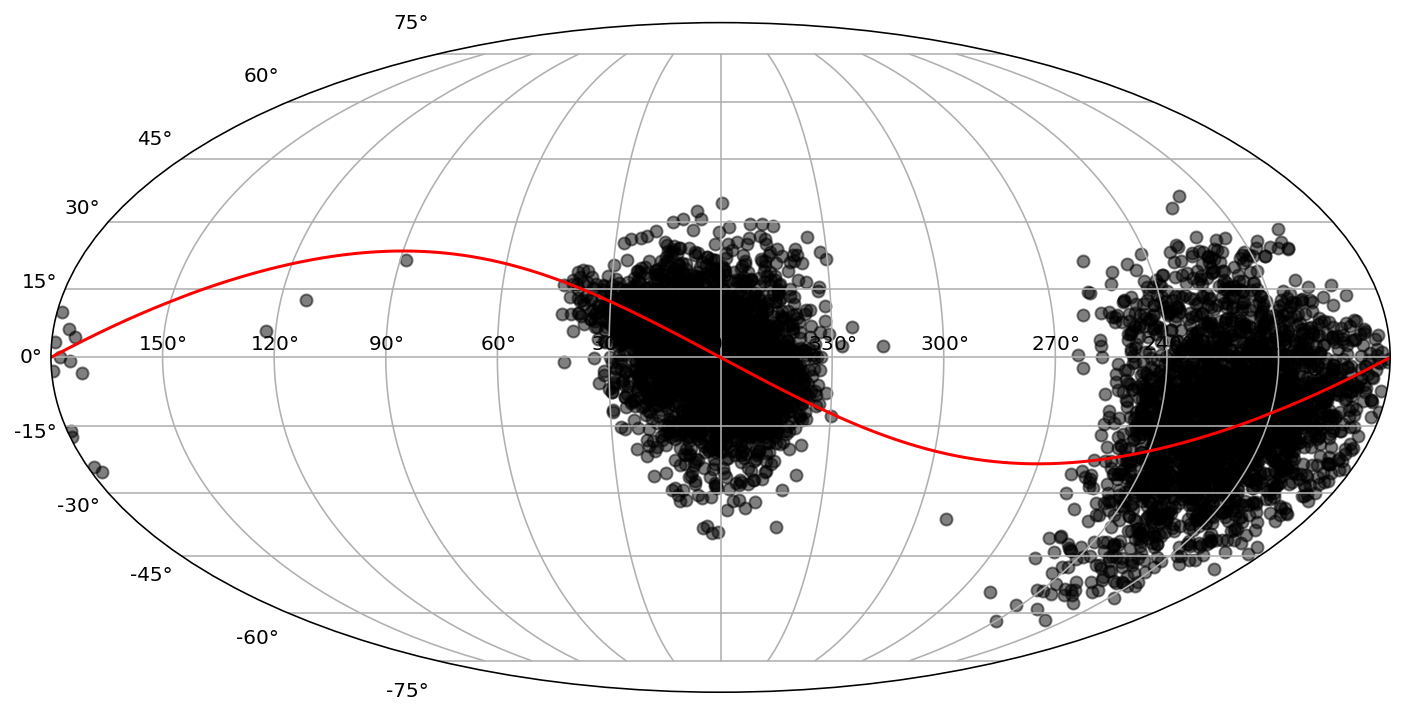

In [5]:
rocks.plot_radec()